In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy, deepcopy
from scipy import special
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import colorConverter
import time
import pystencils
import sympy
from lbmpy.session import *
import math

In [2]:
### CONSTANTS

# The value of the ambient lighting, i.e., when there's a shadow. Should be
#   0 <= ambient_strenght <= 1
AMBIENT_STRENGTH = 0.25
# The value of cells that have direct sunlight. Should be
#   0 <= sunlight_strength <= 1
SUNLIGHT_STRENGTH = 1.0

# Initial force of the lbm simulation
FORCE = 1e-7
# Determines if the LBM simulation is a box (True) or a more spherical design (False)
DUCT = True
# The method used in the LBM simulation
METHOD = "cumulant"
# The viscosity of the fluid in the LBM simulation
RELAXATION_RATE = 1.9

In [3]:
### SUNLIGHT CONCENTRATIONS

def spawn_lighty_lighty(N):
    """
        Computes the initial sunlight matrix, i.e., sets everything to the
        sunlight value
        
        Parameters:
          - N: The width/height of the box we simulate
          
        Returns:
        An N x N matrix describing the sunlight concentrations for the first
        timestep
    """
    
    return np.array([[SUNLIGHT_STRENGTH for _ in range(N)] for _ in range(N)])

def growth_lighty_lighty(new_pixel, sunlight_mat, copy=True):
    """
        Given the location of the new pixel and the existing sunlight matrix,
        we update the sunlight matrices to include the new shadow
        
        Parameters:
          - new_pixels: tuple of (y, x) coordinates for the new pixel
          - sunlight_mat: An N x N matrix with the old sunlight concentrations
          - copy: If set to True, does not change the sunlight_mat directly but
            instead returns a new copy. (Default: True)

        Returns:
        An N x N matrix with new new sunlight concentrations yaaay
    """
    
    # Copy the sunlight matrix if needed
    if copy:
        sunlight_mat = sunlight_mat.copy()
    
    # Unpack the pixel coordinates
    y, x = new_pixel
    
    # Set the pixel to 0, to indicate that it's occupied with coral
    sunlight_mat[y, x] = 0
    
    # Loop down from there to 'cast' the shadow
    for iy in range(new_pixel[0] - 1, -1, -1):
        # If we happen to find a pixel/ambient strength, then we can stop early
        if sunlight_mat[iy, x] != SUNLIGHT_STRENGTH:
            break
        
        # Otherwise, cast the shadow
        sunlight_mat[iy, x] = AMBIENT_STRENGTH
    
    # We're done
    return sunlight_mat

def destroy_lighty_lighty(N, removed_coords, sunlight_mat, object_mat, copy = True):
    """
        Given lists of pixels that are removed, recomputes the shadow on their
        columns.
        
        Parameters:
          - N: The width/height of the box we simulate
          - removed_coords: List of (y, x) tuples describing each of the pixels
          - sunlight_mat: N x N matrix describing the sunlight concentrations
            at the previous step.
          - object_mat: N x N matrix of 1's and 0's describing where the coral
            lives. Assumes that the removed pixels have already been removed.
          - copy: If set to True, does not change the sunlight_mat directly but
            instead returns a new copy. (Default: True)
        
        Returns:
        An N x N matrix describing the sunlight at the next timestep
    """
    
    # Copy the sunlight matrix if needed
    if copy:
        sunlight_mat = sunlight_mat.copy()
        
    # Find the unique columns
    columns = set({ coord[1] for coord in removed_coords })
    
    # Loop thru the columns
    for x in columns:
        # Loop thru the column itself, spreading sunlight where we go
        for y in range(N - 1, -1, -1):
            # If it's a coral, then we can assume the rest is still shadow
            if object_mat[y, x] == 1:
                break
            
            # Otherwise, set the big sunlight
            sunlight_mat[y, x] = SUNLIGHT_STRENGTH
    
    # We're done already
    return sunlight_mat

In [24]:
### FLOW CONCENTRATIONS

def velocity_info_callback(boundary_data, activate=True, **_):
    """
        Function to be able to activate and deactivate inflow speed
        
        Parameters:
          - boundary_data: the data for the lbmpy package that defines the
            boundary conditions
          - activate: whether or not the flow is activated
    """
    boundary_data['vel_1'] = 0
    if activate==True:
        u_max = 0.05
        boundary_data['vel_0'] = u_max 
    else:
        boundary_data['vel_0'] = 0

def init_flow(seed_coord_x, N, initial_iterations = 50):
    """
        Function to initialize the flow density matrix. Also runs it a couple
        of times to spread the flow a lil'.
        
        Parameters:
          - seed_coord_x: The x-coordinate of the seed
          - N: The width/height of the box we simulate
          - initial_iterations: The number of iterations we run the simulation
            to get the flow going a little bit. (Default: 50)

        Returns:
          - A new LBMpy object with the prepared scenario
          - Snapshots_vel: List that contains the snapshots of the flow, for
            plotting
    """
    
    # Initialize the LBMpy object
#     scenario = create_channel(
#         domain_size = (N, N),
#         force = FORCE,
#         duct = DUCT,
#         method = METHOD,
#         relaxation_rate = RELAXATION_RATE
#     )
    initial_velocity = np.zeros((N, N) + (2,))
    initial_velocity[:, :, 0] =  0.08
    scenario = create_fully_periodic_flow(
        initial_velocity,
        method='cumulant',
        relaxation_rate=1.9
    )
    
    # Set the boundary of the LBM
    stencil = get_stencil("D2Q9")
    outflow = ExtrapolationOutflow(stencil[4], scenario.method)
    scenario.boundary_handling.set_boundary(outflow, make_slice[:,N])
    inflow = UBB(velocity_info_callback, dim=scenario.method.dim)
    scenario.boundary_handling.set_boundary(inflow, make_slice[0, :])
    scenario.boundary_handling.set_boundary(NoSlip(), make_slice[:, 0])
    
    # Prepare the simulation with only the seed pixel
    flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[seed_coord_x, 0])
    
    # List to save snapshots
    snapshots_vel = []
    snapshots_vec = []
    
    # Run the simulation n times
    for _ in range(initial_iterations):
        scenario.run(1)
#         figure_coral_with_flow(scenario)
        snappy = deepcopy(scenario.velocity[:,:,0])
        snapshots_vel.append(snappy)
        snapshots_vec.append(deepcopy(scenario.velocity_slice()))
    
    # The scenario is noweth ready
    return scenario, snapshots_vel, snapshots_vec



def update_flow(object_mat, scenario, snapshots_vel, snapshots_vec, n_steps = 1):
    """
        Function to compute the flow density matrix ed for the next time step.

        Parameters:
          - object_mat: N x N matrix describing where the coral lives.
          - scenario: LBMpy scenario describing the flow at the previous
            timestep
          - snaptshots_vel: List of snapshots of velocities, for the movies
          - n_steps: How many steps to update the flow (Default: 1)

        Returns:
        A tuple of:
          - The given LBM scenario
          - The list of snapshots of the velocity, for el movie
    """

    # set noslip boundary around object
    for y in range(N - 1):
        for x in range(1, N - 1):
            if object_mat[y, x] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[x, y])
    
    # run lbm 10 steps, saving at each step for movie
    for _ in range(n_steps):
        scenario.run(1)
        snappy = deepcopy(scenario.velocity[:,:,0])
        snapshots_vel.append(snappy)
        snapshots_vec.append(deepcopy(scenario.velocity_slice()))
    return scenario, snapshots_vel, snapshots_vec

In [25]:
### NUTRIENT CONCENTRATIONS

def diffusion_update(conc_mat, omega):
    """
        Function to calculate the difference in the nutrient concentration
        based on the diffusion.
        Uses SOR method, only right boundary is calculated (rest are sink
        boundaries, with standard set to 0)
        
        Parameters:
          - conc_mat: nutrient concentration matrix
          - omega: relaxation parameter
        
        Returns:
        A matrix with the difference in nutrient concentration caused by diffusion.
    """
    
    # Initialize the update result
    diff_update = np.zeros((N,N))

    # middle of matrix
    for j in range(1,N-1):
        for i in range(1,N-1):
            diff_update[i][j] = (omega/4)*(conc_mat[i+1][j] + conc_mat[i-1][j] + conc_mat[i][j+1] + conc_mat[i][j-1]) - omega*conc_mat[i][j]

    # right boundary
    for k in range(1,N-1):
        diff_update[k][N-1] = omega/4*(conc_mat[k+1][N-1] + conc_mat[k-1][N-1]  + conc_mat[k][N-2]) - omega*conc_mat[k][N-1] # + conc_mat[k][0]

    return diff_update

def convection_update(nut_mat, scenario):
    
    """
        Calculates the difference in nutrient concentration caused by the
        convection (flow).
        
        Parameters:
          - nut_mat: nutrient concentration matrix
          - scenario = channel with lattice Boltzmann flow, velocity profile.
        
        Returns:
        Matrix with the difference in nutrient concentration caused by
        convection.
    """
    
    # TODO: Ask Malou if this flip goes alright
    # Prepare the result matrix
    conv_update = np.zeros((N, N))
    velocties = scenario.velocity_slice()
    
    # flow to the right
    conv_flow_right = np.transpose(velocties[:-1,:,0])*nut_mat[:,:-1]
    conv_flow_right[np.where(conv_flow_right < 0)] = 0
    conv_update[:,:-1] -= conv_flow_right
    conv_update[:,1:] += conv_flow_right
    
    # flow to the left
    conv_flow_left = np.transpose(velocties[2:,:,0])*nut_mat[:,2:]
    conv_flow_left[np.where(conv_flow_left > 0)] = 0
    conv_update[:,2:] -= conv_flow_left
    conv_update[:,1:-1] += conv_flow_left
    
    # flow up 
    conv_flow_up = np.transpose(velocties[1:,:-1,1])*nut_mat[:-1,1:]
    conv_flow_up[np.where(conv_flow_up < 0)] = 0
    conv_update[:-1,1:] -= conv_flow_up
    conv_update[1:,1:] += conv_flow_up
    
    # flow down
    conv_flow_down = np.transpose(velocties[1:,1:,1])*nut_mat[1:,1:]
    conv_flow_down[np.where(conv_flow_down > 0)] = 0
    conv_update[1:,1:] -= conv_flow_down
    conv_update[:-1,1:] += conv_flow_down
    
    # done
    return conv_update

def init_nut(N, omega, object_mat, scenario, nut_inflow, initial_iterations = 2000):
    """
        Initializes the nutrition matrix by running it a lot of times.
        
        Parameters:
          - N: The width/height of the box we simulate
          - omega: Relaxation parameter
          - object_mat: N x N coral matrix of 1's and 0's
          - scenario: The LBMpy object needed for the flow part of the
            computation
          - snapshots_grad: List of snapshots of the gradient for animation.
          - nut_inflow: The strength of the new nutrition concentrations that
            spawn
          - initial_iterations: Number of iterations to 'dry run' the nutrition
            (Default: 2000)
        
        Returns:
        The nutrition matrix, ready to let coral grow
    """
    
    # Spawn the matrices
    nut_mat = np.zeros((N, N))
    snapshots_grad = []
    
    # Set the boundries
    nut_mat[:, 0:int(N / 10)] = nut_inflow
    
    # Update the nutrition matrix the desried number of times
    for _ in range(initial_iterations):
        # Perform the update
        nut_mat = update_nut(nut_mat, omega, scenario, object_mat, nut_inflow, copy=False)
        snapshots_grad.append(nut_mat.copy())
    
    # Return
    return nut_mat, snapshots_grad

def update_nut(nut_mat, omega, scenario, object_mat, nut_inflow, copy=True):
    """
        Combines the convection matrix and diffusion matrix.
        
        Parameters:
          - nut_mat: The nutrition matrix at the previous timestep
          - omega: relaxation parameter
          - scenario: object for the LBMpy simulation s.t. it knows its state
          - object_mat: N x N matrix that describes the coral once again
          - nut_inflow: The strength of the new nutrition concentrations that
            spawn
          - copy: Whether or not to copy the nut_mat before altering it.
            (Default: True)
        
        Returns:
        The new nutrition matrix
    """

    # If we want to copy, then copy the nut_mat
    if copy:
        nut_mat = nut_mat.copy()
        
    # Compute the convection & diffusion parts of the update first
    update_diff = diffusion_update(nut_mat, 0.7)
    update_conv = convection_update(nut_mat, scenario)
    
    # Perform the update
    nut_mat += update_conv + update_diff
    
    # Fix the negative values in the matrix for stability
    nut_mat[nut_mat < 0] = 0
    
    # Also set the coral values to have no nutritions (coral isn't edible apparently)
    nut_mat[object_mat == 1] = 0
    
    # Fix the boundries of the nutrient matrix
    nut_mat[:,  0] = nut_inflow
    nut_mat[:, -1] = 0
    nut_mat[ 0, :] = 0
    nut_mat[-1, :] = 0
    
    # Done
    return nut_mat

In [26]:
### EROSION

def coral_breaky_breaky(N, seed_coord_x, threshold, object_mat, vector_field, sunlight_mat, copy=True):
    """
        Function that computes if the coral is gonna breaky breaky
        
        Parameters:
          - N: The width/height of the box we simulate in
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - threshold: The maximum force before a coral block erodes away
          - object_mat: a numpy array of 0's and 1's that determine where
            the coral is
          - vector_field: (I assume?) een numpy array of 2D vectors
          - sunlight_mat: N x N matrix describing the sunlights, which will be
            updated in case a pixels breaks.
          - copy: If True, does not modify the original object but instead
            returns a new one
          
        Returns:
          - The coral matrix with the relevant pixels removed
          - Broken boolean: True if part of coral got removed, else False
          
        O.O does it work?
    """
    
    # Copy the matrix if the user so desires
    if copy:
        object_mat = object_mat.copy()

    # Keep track whether part of coral has broken off
    broken = False

    # Loop through the coral matrix to find the corals
    for y in range(N):
        for x in range(N):
            if (x == seed_coord_x and y == 0) or object_mat[y, x] == 0: continue

            # Compute the pressure at this point (i.e., length of the vector)
            pressure = math.sqrt(vector_field[y, x][0]**2 + vector_field[y, x][1]**2)
#             print(vector_field[y, x], pressure)

            # If the pressure exceeds the threshold, remove the coral (:()
            if pressure > threshold:
                object_mat[y, x] = 0
                # Recompute the sunlight for this removed pixel
                destroy_lighty_lighty(N, [(y, x)], sunlight_mat, object_mat, False)
                broken = True

    # We're done! Return the results
    return object_mat, broken

def coral_painty_painty(seed_coord_x, object_mat, sunlight_mat, copy=True):
    """
        Function that checks which pixels are still connected to the source,
        and removes them. Also returns a new list of potential growth
        candidates.
        
        Note: We assume that a diagonal connection == no connection
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - object_mat: a numpy array of 0's and 1's that determine where
            the coral is
          - sunlight_mat: N x N matrix describing the sunlights, which will be
            updated in case a pixels breaks.
          - copy: If True, does not modify the original object but instead returns a new one
        
        Returns:
        A tuple of:
          - The coral matrix, with all the unconnected pixels removed
          - A new list of growth candidates
    """
    
    # Copy the matrix if the user so desires
    if copy:
        object_mat = object_mat.copy()
        
    # Do a breadth-first search starting at the seed to see which pixels are connected to the seed
    object_mat[0, seed_coord_x] = 2
    to_do = [(0, seed_coord_x)]
    candidates = set()
    while len(to_do) > 0:
        # Fetch the pixel to check
        y, x = to_do[0]
        to_do = to_do[1:]
        
        # Get the area around the pixel
        for neighbour in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
            ny = y + neighbour[0]
            nx = x + neighbour[1]

            # Skip if the pixel is out-of-bounds
            if nx < 0 or nx > object_mat.shape[0] - 1 or ny < 0 or ny > object_mat.shape[1] - 1:
                continue

            # If the pixel is not a pixel, then store it as possible growth candidate
            if object_mat[ny, nx] == 0:
                # Uncomment for the correct candidates order
#                 candidates.add((nx, ny))
                candidates.add((ny, nx))
            
            # If it is an (unvisited) pixel, then mark as visited/connected and add it to the todo list
            if object_mat[ny, nx] == 1:
                # Mark the pixel as connected
                object_mat[ny, nx] = 2
                
                # Add to the queue
                to_do.append((ny, nx))
    
    # Fetch the coordinates of the 1's
    removed_pixels = np.where(object_mat == 1)
    removed_coords = list(zip(*removed_pixels))
    
    # Go thru the matrix again and remove anything that's a 1
    object_mat[object_mat == 1] = 0
    # Convert the visited pixels back to 1's
    object_mat[object_mat == 2] = 1
    
    # Update the sunlight matrix to get rid of the ol' shadows
    destroy_lighty_lighty(N, removed_coords, sunlight_mat, object_mat, False)
    
    # Done!
    return object_mat, candidates

In [27]:
### GAME LOOP

def get_candidates(object_loc, object_mat, candidates):
    """
        Function to find the neighbours of an object cell,
        if they qualify as growth candidates, add to set 
        (so all candidates are unique).
        
        Parameters:
          - object_loc: coordinates tuple of new object cell
          - object_mat: a numpy array of 0's and 1's that determine where
            the object is
          - candidates: a set of tuples containing the candidate coordinates
        
        Returns:
        The updated candidate set
    """

    # Get object coordinates
    y = object_loc[0]
    x = object_loc[1]

    # check if edirect neighbours are NOT part of object, and add them to candidates
    if x != N - 1 and object_mat[y][x + 1] == 0:
        candidates.add((y, x + 1))
        
    if x != 0 and object_mat[y][x - 1] == 0:
        candidates.add((y, x - 1))
        
    if y != N - 1 and object_mat[y + 1][x] == 0:
        candidates.add((y + 1, x))
        
    if y != 0 and object_mat[y - 1][x] == 0:
        candidates.add((y - 1, x))

    return candidates



def choose_growth(N, eta, alpha, sunlight_mat, nut_mat, candidates, object_mat):
    """
        Function to calculate growth probabilities of each candidate cell,
        choose one and grow it this timestep.
        
        Also breaks the coral due to errosion.

        Parameters:
          - N: grid size (NxN)
          - eta: weight of concentration gradient for growth
          - alpha: weight of influence of sun vs nutrients
          - sunlight_mat: numpy array containing all sunlight concentrations
            per coordinate
          - candidates: set of tuple coordinates of all growable cells 
          - object_mat: N x N array of 1's and 0's describing where the color
            is

        Returns:
        - Location of the new pixel as (y, x) tuple
        - Updated object_mat matrix with newly grown object cell
        - Updated candidate set
    """
    
    # TODO: add necessary input constants as arguments (nutrient diff)
    
    probs = []  # store all candidate grow probabilities
    list_candidates = list(candidates)  # ensure same ordering 
    
    # Normalize the sun concentrations to probabilities
    total = np.sum([sunlight_mat[cand] ** eta for cand in list_candidates])
    if total == 0:
        probs_sun = [1 / len(list_candidates) for _ in list_candidates]
    else:
        probs_sun = [sunlight_mat[cand] ** eta / total for cand in list_candidates]
    
    # Normalize the nutritient concentrations to probabilities
    total = np.sum([nut_mat[cand] ** eta for cand in list_candidates])
    if total == 0:
        probs_nut = [1 / len(list_candidates) for _ in list_candidates]
    else:
        probs_nut = [(nut_mat[cand] ** eta) / total for cand in list_candidates]
    
    # Join them together using the alpha weighted average
    probs = [alpha * probs_sun[i] + (1 - alpha) * probs_nut[i] for i in range(len(list_candidates))]

    # choose a candidate and grow
    chosen_growth = list_candidates[np.random.choice(len(candidates), p=probs)]
    object_mat[chosen_growth] = 1
    sunlight_mat[chosen_growth] = 0
    # update candidate set after growth
    candidates = get_candidates(chosen_growth, object_mat, candidates)
    # delete newly grown cell from growth candidates
    candidates.remove(chosen_growth)

    # Possibly break the coral
    return chosen_growth, object_mat, candidates



def SOR_DLA_to_solution(N, eta, omega, alpha, threshold, nut_inflow, iterations):
    """
        Function to calculate the SOR of a grid with object, 
        until convergence, with growing object
        
        Parameters:
          - N: desired grid size (NxN)
          - eta: weight of concentration gradient for growth
          - omega: SOR equation constant
          - alpha: weight of influence of sun vs nutrients
          - nut_inflow: The strenght of new nutrients that spawn left in the
            box.
          - iterations: how many times the object should grow
        
        Returns:
        - The concentration matrix
        - The object_mat matrix with fully grown object
        - The densitity list with coral density at each iteration
    """
    
    # Compute the source location (middle)
    seed_coord_x = int(N / 2)

    # Keep track of coral density at each iteration
    density_list = []
    
    # Initalisation of matrix with seed of object
    object_mat = np.zeros((N, N))
    object_mat[0, seed_coord_x] = 1
    candidates = set()
    candidates = get_candidates((0, seed_coord_x), object_mat, candidates)
    
    # Initialize starting concentrations
    sunlight_mat = spawn_lighty_lighty(N)
    scenario, snapshots_vel, snapshots_vec = init_flow(seed_coord_x, N)
    nut_mat, snapshots_grad = init_nut(N, omega, object_mat, scenario, nut_inflow, initial_iterations=2000)
#     print(snapshots_grad)
    
    # Prepend the 50 iterations of nutrients to compensate for the velocities
    snapshots_grad = [np.zeros((N, N)) for _ in range(50)] + snapshots_grad
    
    # Append the flow with 2000 iterations to compensate for the nut
    snapshots_vel += [scenario.velocity[:, :, 0].copy() for _ in range(2000)]
    snapshots_vec += [scenario.velocity_slice().copy() for _ in range(2000)]
    
    # Generate the sunlight and object snapshot, with enough iterations to cover the timespan of the scenario
    snapshots_sun = [sunlight_mat.copy() for _ in range(2050)]
    snapshots_obj = [object_mat.copy() for _ in range(2050)]

    # loop until object is grown 'iterations' times, recomputing the sunlight with each growth
    for _ in range(iterations):
#         figure_coral_with_flow(scenario)
        
        # Grow the coral
        new_pixel, object_mat, candidates = choose_growth(N, eta, alpha, sunlight_mat, nut_mat, candidates, object_mat)
        snapshots_obj.append(object_mat.copy())
        
        # Update the flow using Lattice-Boltzmann
        scenario, snapshots_vel, snapshots_vec = update_flow(object_mat, scenario, snapshots_vel, snapshots_vec)
        
        # Update the sunlight matrix according to the new pixel
        sunlight_mat = growth_lighty_lighty(new_pixel, sunlight_mat, copy=False)
        snapshots_sun.append(sunlight_mat.copy())
        
        # Compute the nutrient concentration matrix for the next timestep
        nut_mat = update_nut(nut_mat, omega, scenario, object_mat, nut_inflow, copy=False)
        snapshots_grad.append(nut_mat.copy())
        
        # Finally, break the coral based on the vectors generated by the LBM
        vector_field = scenario.velocity
        _, broken = coral_breaky_breaky(N, seed_coord_x, threshold, object_mat, vector_field, sunlight_mat, copy=False)
        if broken:
            _, candidates = coral_painty_painty(seed_coord_x, object_mat, sunlight_mat, copy=False)
        
        # Compute the branch factor/density of the graph for analysis
        density_list.append(branch_factor(object_mat))


    # We're done!
    return snapshots_obj, snapshots_vel, snapshots_vec, snapshots_sun, snapshots_grad, density_list

In [28]:
### DENSITY / ANALYSIS

from scipy.optimize import curve_fit

def branch_factor(coral_matrix):
    """
        Function that computes The fraction of coral cells which are edge cells. 
        The lower the number the more dense the coral is.
        Parameters:
          - coral matrix
        
        Returns:
            The fraction of cells which are touching the sea.
    """
    edge_cells = set()
    coral_size = 0
    for row in range(len(coral_matrix)):
        for element in range(len(coral_matrix)):
            # If cell is not coral, continue            
            if coral_matrix[row][element] == 0:
                continue
            else:
                coral_size += 1
                # Check all neighbours
                for neighbour in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
                    ny = row + neighbour[0]
                    nx = element + neighbour[1]
            
                    # Skip if the pixel is out-of-bounds
                    if ny < 0 or ny > coral_matrix.shape[0] - 1 or nx < 0 or nx > coral_matrix.shape[1] - 1:
                        continue
                        
                    # If neighbour is sea, the cell is an edge.
                    if coral_matrix[ny, nx] == 0:
                        edge_cells.add((row, element))
                        break

    return len(edge_cells) / coral_size



def fractal_dimension(N, object_mat):
    """
    Function to calculate the fractal dimension of the object. 
    
    Parameters:
      - N: The width/height of the box we simulate
      - object_mat: The N x N matrix describing the coral
           
    Returns:
    Box-counts for different box sizes, fractal dimension.
    """
    
    # Define a local function to compute the powerlaw
    func_powerlaw = lambda x, k, c, c0: c0 + x**k * c
    # Define a local function to plot a straight line
    line = lambda m, x, b: m*x+b
    
    # find amount of different block sizes (here = 6)
    size = N
    m = int(np.log(size)/np.log(2))

    # list to save the counts of the blocks containing a '1'
    cnts = []

    # for each in the different block sizes, calculate a block size, and find how many of the blocks contain '1'
    for lev in range(m):
        block_size = 2**lev
        cnt = 0
        for j in range(int(size/(2*block_size))):
            for i in range(int(size/block_size)):
                cnt = cnt + object_mat[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size].any()
        cnts.append(cnt)

    # set block size + amount of blocks containing a '1' in a data array
    data = np.array([(2**(m-(k+1)),cnts[k]) for k in range(m)])
    xs = data[:,0]
    ys = data[:,1]

    # calculate logs + plot the points
    xs_log = np.log(data[:,0])
    ys_log = np.log(data[:,1])
    plt.plot(xs_log, ys_log, 'o')

    # fit a straight line through log plots, slope = fractal dimension
    A = np.vstack([xs_log, np.ones(len(xs))]).T
    fract_dim, b = np.linalg.lstsq(A, ys_log, rcond=-1)[0]
    
    ys_fitted = line(fract_dim, xs_log, b)

    # plot the fitted line
    plt.plot(xs_log, ys_fitted)
    plt.title('Fitted line through log of box-counts')
    plt.show()

    # plot the log-log plot of the data (shows log axes)
    plt.loglog(data[:,0],data[:,1])
    plt.title('Log-log plot of box-counts')
    plt.show()

    # fit a powerlaw through the points and plot
    popt, pcov = curve_fit(func_powerlaw, data[:,0], data[:,1])
    plt.figure(figsize=(10, 5))
    plt.plot(data[:,0], func_powerlaw(data[:,0], *popt), '--')
    plt.plot(data[:,0], data[:,1], 'ro')
    plt.show()
    
    print('Fractal dimension: ', fract_dim)
    return data, fract_dim

In [29]:
### PLOTTING

import os
from progressBar import ProgressBar

def plot_object_gradient(conc_mat, object_mat, eta, file=None):
    """
        Function to make a combined imshow plot, where the object is visible
        along with the gradient.
        
        Code (with small adjustments) based on answer at:
        https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
        
        Parameters:
          - conc_mat: N x N matrix with the gradient to plot
          - object_mat: N x N matrix with the coral to plot
          - eta: constant used to control how large the gradient is
          - file: If not None, writes to the given file instead of showing the
            plot. (Default: None)
    """
    
    # Remove any previous bars
    plt.clf()
    
    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2', [color1,color2], 256)
    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N + 3)
    cmap2._lut[:, -1] = alphas

    img2 = plt.imshow(conc_mat, interpolation='nearest', cmap='Spectral', origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar()
    img3 = plt.imshow(object_mat, interpolation='nearest', cmap=cmap2, origin='lower', extent=[0, 1, 0, 1])

    plt.title(f"Object with gradient, eta = {eta}")

    # Either show or save
    if file is None:
        plt.show()
    else:
        plt.savefig(file)

        
        
def snapshots_to_mp4(snapshots, snapshots_obj, eta, filename, temp_name="temp/<i>.png", fps=25, mode="gradient"):
    """
        Function that plots the given list of snapshots and saves them as an
        mp4. Note that the intermediate disk usage may be quite high, and that
        we assume the ffmpeg Ubuntu exec is installed.
        
        If not, try:
           sudo apt-get install ffmpeg
        
        Parameters:
          - snapshots: the list of (gradient) snapshots we want to plot
          - snapshots_obj: list of object matrices, showing the coral growth
          - eta: constant used to control how large the gradient is
          - filename: resulting name of the movie.
          - temp_name: template for the intermediate pictures. Use '<i>' to
            indicate where in the name the photo's index should be.
            Default: 'temp/<i>.png'
          - fps: the frames per second of the resulting image. (Default: 25)
        
        Returns:
        Nothing directly, but the chosen filename should now exist as an .mp4
    """
    
    # First, check the temp_name validity
    if temp_name.count("<i>") != 1:
        raise ValueError("temp_name should include exactly one '<i>' to indicate the number location")
    
    # Sanity check that the two lists have the same length
    if len(snapshots) != len(snapshots_obj):
        raise ValueError(f"snapshots and snapshots_obj do not have the same length ({len(snapshots)} vs {len(snapshots_obj)})")
    
    # Before we run, delete the existing pics
    os.system(f"rm -f {temp_name.replace('<i>', '*')}")
    
    # Next, start pumping out plots; but note file errors
    try:
        prgs = ProgressBar(width=100, max_amount=len(snapshots) - 1)
        for i in range(len(snapshots)):
            if mode == "gradient":
                plot_object_gradient(snapshots[i], snapshots_obj[i], eta, temp_name.replace("<i>", f"{i:05d}"))
            elif mode == "vector":
                plt.clf()
                plt.vector_field(snapshots[i]);
                plt.savefig(temp_name.replace("<i>", f"{i:05d}"), dpi=200)
            else:
                raise ValueError(f"Unknown mode '{mode}'")
            prgs.update()
        
    except OSError as e:
        print(f"ERROR: Could not write to file '{e.filename}': {e.strerror}")
        return
    
    # With that done, call ffmpeg
    cmd = f"ffmpeg -y -r {fps} -i {temp_name.replace('<i>', '%05d')} -c:v libx264 -pix_fmt yuv420p {filename}"
    print(f"Combining images with: '{cmd}'")
    os.system(cmd)
    
    # Done!
    

    
def figure_coral_with_flow(scenario, mode="vector", file=None):
    """
        Function to plot the coral flow, either as vector field or as density
        field.
        
        Parameters:
          - scenario: LBMpy scenario describing the current flow
          - mode: Draw mode, either 'vector' for vectors or 'scalar' for
            density (default: vector).
          - file: If not None, writes to the given file instead of showing the
            plot. (Default: None)
        
        Returns:
        Nothing, but does show a pyplot.
    """

    plt.figure(dpi=200)
    if mode == "vector":
        plt.vector_field(scenario.velocity_slice());
    elif mode == "scalar":
        plt.scalar_field(scenario.velocity[:,:,0])
    plt.colorbar()

    # Either show or save
    if file is None:
        plt.show()
    else:
        plt.savefig(file)

    
    
def amazing_graph(density_list):
    """
        Function that makes a graph of the density of a matrix, saves all intermidiate plots in folder named amazing_graph
        
        Parameters:
          - density_list 
        
        Returns:
        Fills field with graphs, make video with command :ffmpeg -i %04d.png -c:v libx264 -vf fps=2 -pix_fmt yuv420p test_out.mp4
        Make sure to be in path of amazing_graph
    """
    for i in range(len(density_list)):
        current = density_list[0:i]
#         plt.figure(dpi=300)
        plt.plot(current, color='green')
        plt.xlabel("Step number")
        plt.ylabel("Average distance to seed")
        plt.title("Density of Coral over step ")
    #     plt.show()

        plt.savefig(f'amazing_graph/{i:04d}.png')

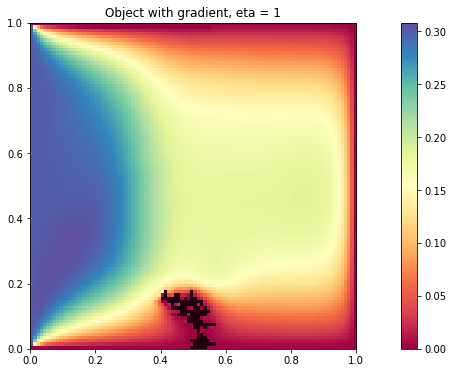

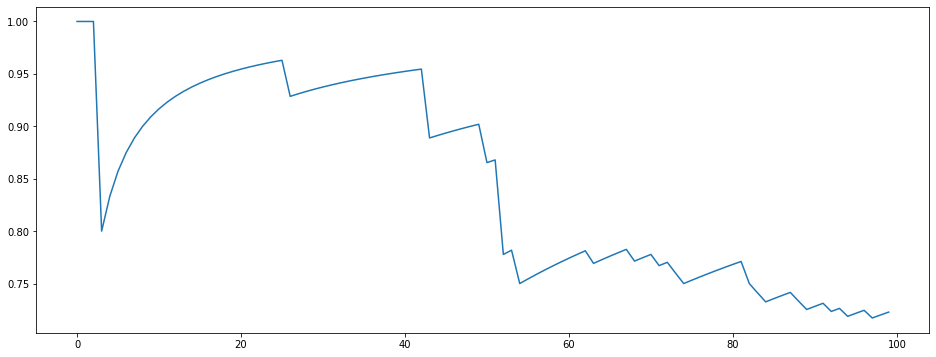

In [30]:
# Test run with just the sunlight computation

N = 100
eta = 1
omega = 1.5
alpha = 0.5
threshold = 5
nut_inflow = 0.3
iterations = 100

snapshots_obj, snapshots_vel, snapshots_vec, snapshots_sun, snapshots_grad, density_list = SOR_DLA_to_solution(N, eta, omega, alpha, threshold, nut_inflow, iterations)
plot_object_gradient(snapshots_grad[-1], snapshots_obj[-1], 1)

plt.plot(density_list)

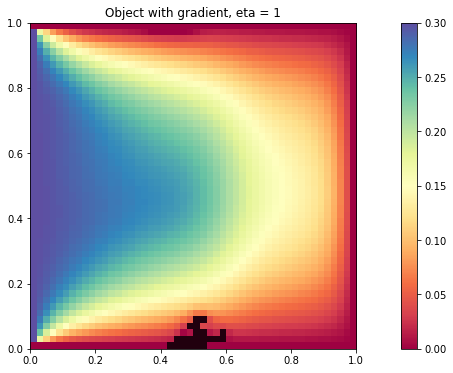

In [11]:
plot_object_gradient(snapshots_grad[-1], snapshots_obj[-1], 1)

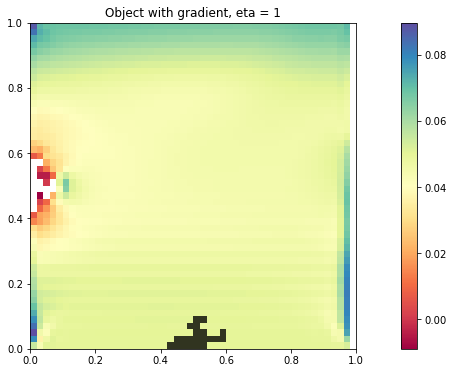

In [12]:
plot_object_gradient(snapshots_vel[-1], snapshots_obj[-1], 1)

In [13]:
class GraphGenerator:
    def __init__(self, iterations, grad, obj):
        # Simply store them
        self.iterations = iterations
        self.grad = grad
        self.obj = obj
        
        # Also note the counter
        self.i = 0
    
    def plot(self):
        # Skip if too far
        if self.i >= self.iterations: return
        
        # Plot one iteration
        plot_object_gradient(self.grad[self.i], self.obj[self.i], 1)
        self.i += 1
        
        # Return the i
        return self.i
        
generator = GraphGenerator(2000, snapshots_grad, snapshots_obj)

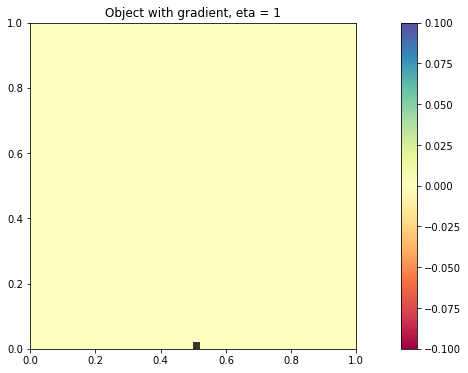

1


In [14]:
print(generator.plot())

 100.0% [==========================================================================================]
Combining images with: 'ffmpeg -y -r 25 -i temp/%05d.png -c:v libx264 -pix_fmt yuv420p gradient.mp4'


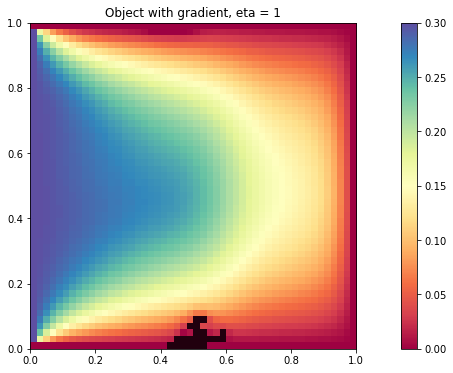

In [15]:
snapshots_to_mp4(snapshots_grad[50:], snapshots_obj[50:], eta, "gradient.mp4", fps=25)

 100.0% [==========================================================================================]
Combining images with: 'ffmpeg -y -r 20 -i temp/%05d.png -c:v libx264 -pix_fmt yuv420p velocity.mp4'


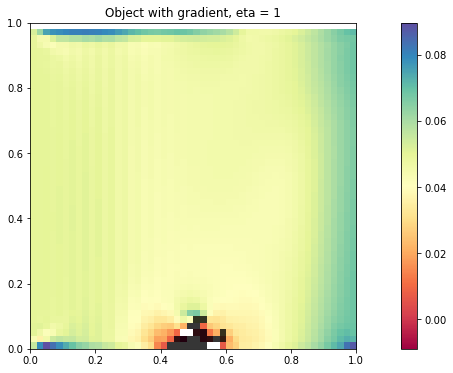

In [16]:
snapshots_vel_T = [np.transpose(snapshot) for snapshot in snapshots_vel[:50] + snapshots_vel[2050:]]
snapshots_to_mp4(snapshots_vel_T, snapshots_obj[:50] + snapshots_obj[2050:], eta, "velocity.mp4", fps=20)

 100.0% [==========================================================================================]
Combining images with: 'ffmpeg -y -r 20 -i temp/%05d.png -c:v libx264 -pix_fmt yuv420p vectors.mp4']


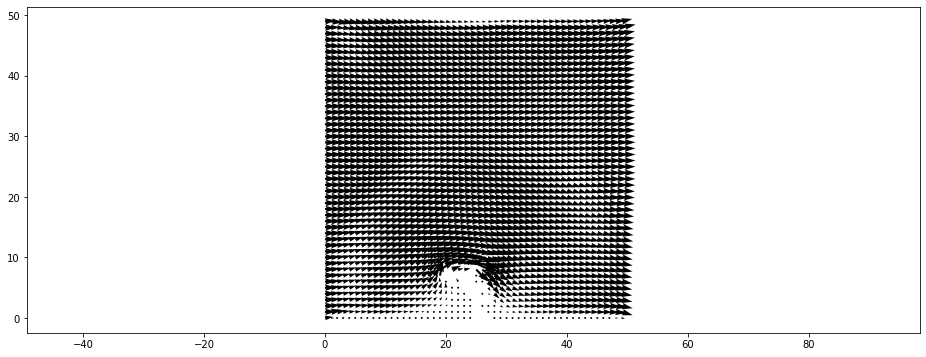

In [31]:
snapshots_to_mp4(snapshots_vec[:50] + snapshots_vec[2050:], snapshots_obj[:50] + snapshots_obj[2050:], eta, "vectors.mp4", fps=20, mode="vector")

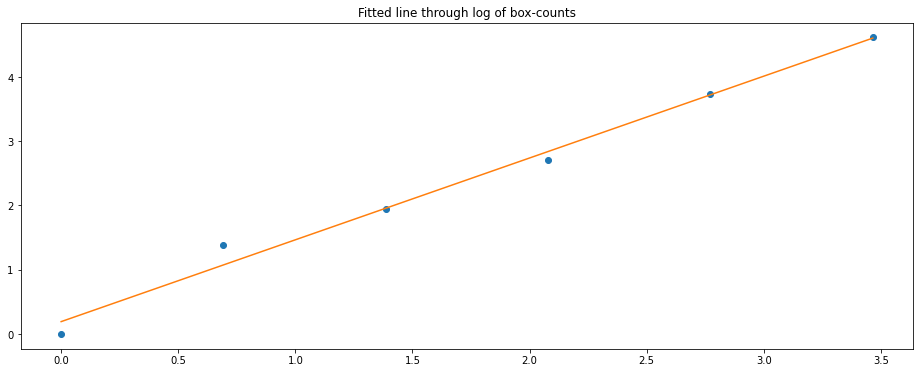

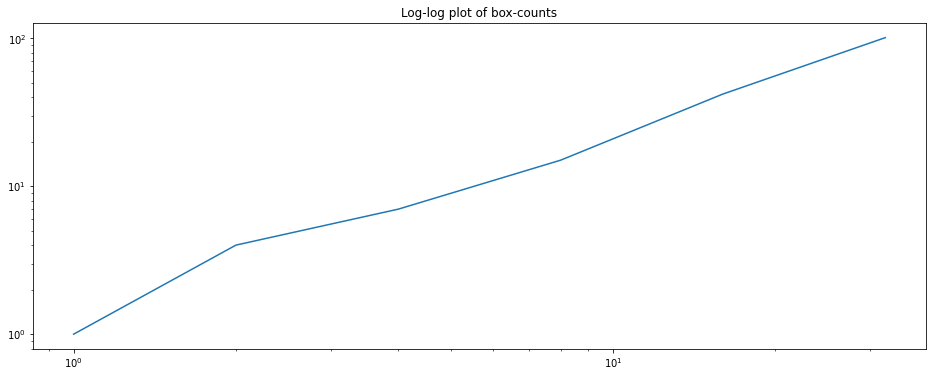

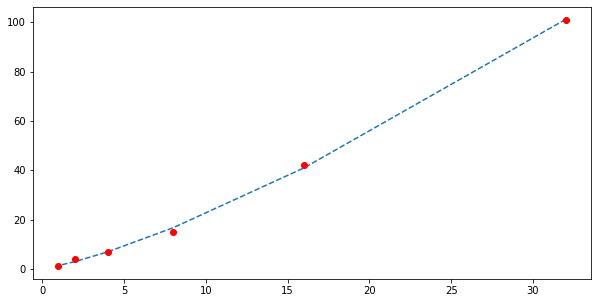

Fractal dimension:  1.2733584387327475
1.2733584387327475
[[ 32 101]
 [ 16  42]
 [  8  15]
 [  4   7]
 [  2   4]
 [  1   1]]


In [23]:
# Compute the fractal dimension
box_counts, dim = fractal_dimension(N, snapshots_obj[-1])
print(dim)
print(box_counts)